# Data Description

Dataset: Prediction of music genre https://www.kaggle.com/vicsuperman/prediction-of-music-genre

Columns:
Acousticness 
- is measured on a scale of 0.0 (not acoustic) to 1.0 (very acoustic). Songs with higher acousticness are more likely to use acoustic and non-electronic instruments

Danceability 
- uantifies how suitable a track is for dancing based on a combination of musical elements, like tempo, rhythm, and beat. Songs with higher danceability have stronger and more regular beats. (goes from 0 to 1)

Duration_ms   
- music duration in milliseconds

energy
- measures the perceived intensity and activity of a song. Energy is also measured on a scale of 0.0 (low energy) to 1.0 (high energy)

instrumentalness
- predicts whether a track contains vocals. Instrumentalness is measured on a scale of 0.0 (likely contains vocal content) to 1.0 (likely contains no vocal content). Songs with higher instrumentalness are less likely to have vocals

key   
- key of the song

liveness
- detects the presence of an audience in a song. Liveness is also measured on a scale of 0.0 (no audience) to 1.0 (audible audience). Songs with higher liveness are more likely to have been performed live.

loudness  
- measures the decibel level of a song. Decibels are relative to a reference value, so songs with lower loudness values are quieter relative to the reference value of 0.


speechiness 
- measures the presence of spoken words in a song. It is measured on a scale of 0.0 (low speechiness) to 1.0 (high speechiness).

tempo 
- measures the beats per minute (bpm) of a song

valence 
- measures the positivity of a song


# Importing libraries to notebook

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Statmodels & patsy
import patsy
import statsmodels.api as sm
from scipy.stats import pearsonr, norm, ttest_ind
from sklearn.metrics import make_scorer, f1_score, accuracy_score, confusion_matrix, classification_report,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics,model_selection,preprocessing
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score,cross_val_predict,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# ER

In [2]:
#importing datasets
music = pd.read_csv('music_genre.csv')
print('=============== showing the data type of each column ===============')
print(music.info())
print('=============== statistical description of numeric data columns ===============')
print(music.describe())
print('=============== showing the number of null value of each column =============== ')
print(music.isnull().sum())

=============== showing the data type of each column ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     

=============== size of dataframe without null value ===============
(50000, 18)


Text(33.0, 0.5, 'missing value count')

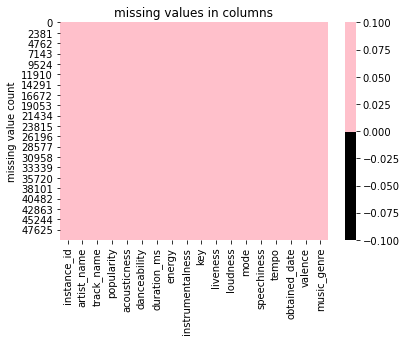

In [25]:
# getting rid of the null values in the dataframe
music = music.dropna(how='any',axis=0)
print('=============== size of dataframe without null value ===============')
print(music.shape)
# using a heatmap to show if there is still missing values 
sns.heatmap(music.isnull(),cmap=['black', 'pink'])
plt.title('missing values in columns')
plt.ylabel('missing value count')

In [3]:
# However, missing values are not all represented by null values
print('=============== the number of missing artist names ===============')
print(music[music['artist_name'] == 'empty_field'].shape[0])

print('=============== the number of negative values in "durations_ms" ===============')
print(music[music['duration_ms'] == -1.0].shape[0])

print('=============== the number of "?" in "tempo" ===============')
print(music[music['tempo'] == "?"].shape[0])

=============== the number of missing artist names ===============
2489
=============== the number of negative values in "durations_ms" ===============
4939
=============== the number of "?" in "tempo" ===============
4980


In [4]:
print('=============== "repetitive genre names "Hip-Hop" and "Rap" ===============')
print(music.music_genre.unique())

=============== "repetitive genre names "Hip-Hop" and "Rap" ===============
['Electronic' 'Anime' nan 'Jazz' 'Alternative' 'Country' 'Rap' 'Blues'
 'Rock' 'Classical' 'Hip-Hop']


Text(0.5, 1.0, 'correlation between column features')

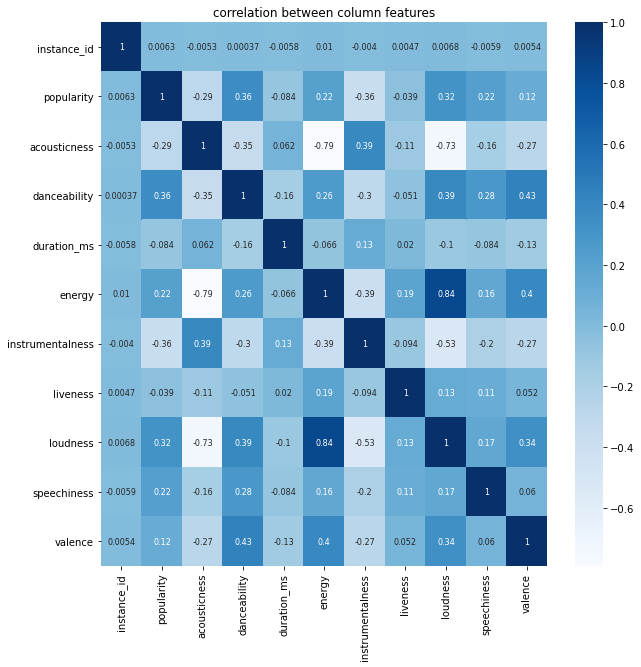

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(music.corr(),annot=True, annot_kws={"size":8}, cmap="Blues").set_title('correlation between column features')

Text(0.5, 1.0, 'correlation between the columns')

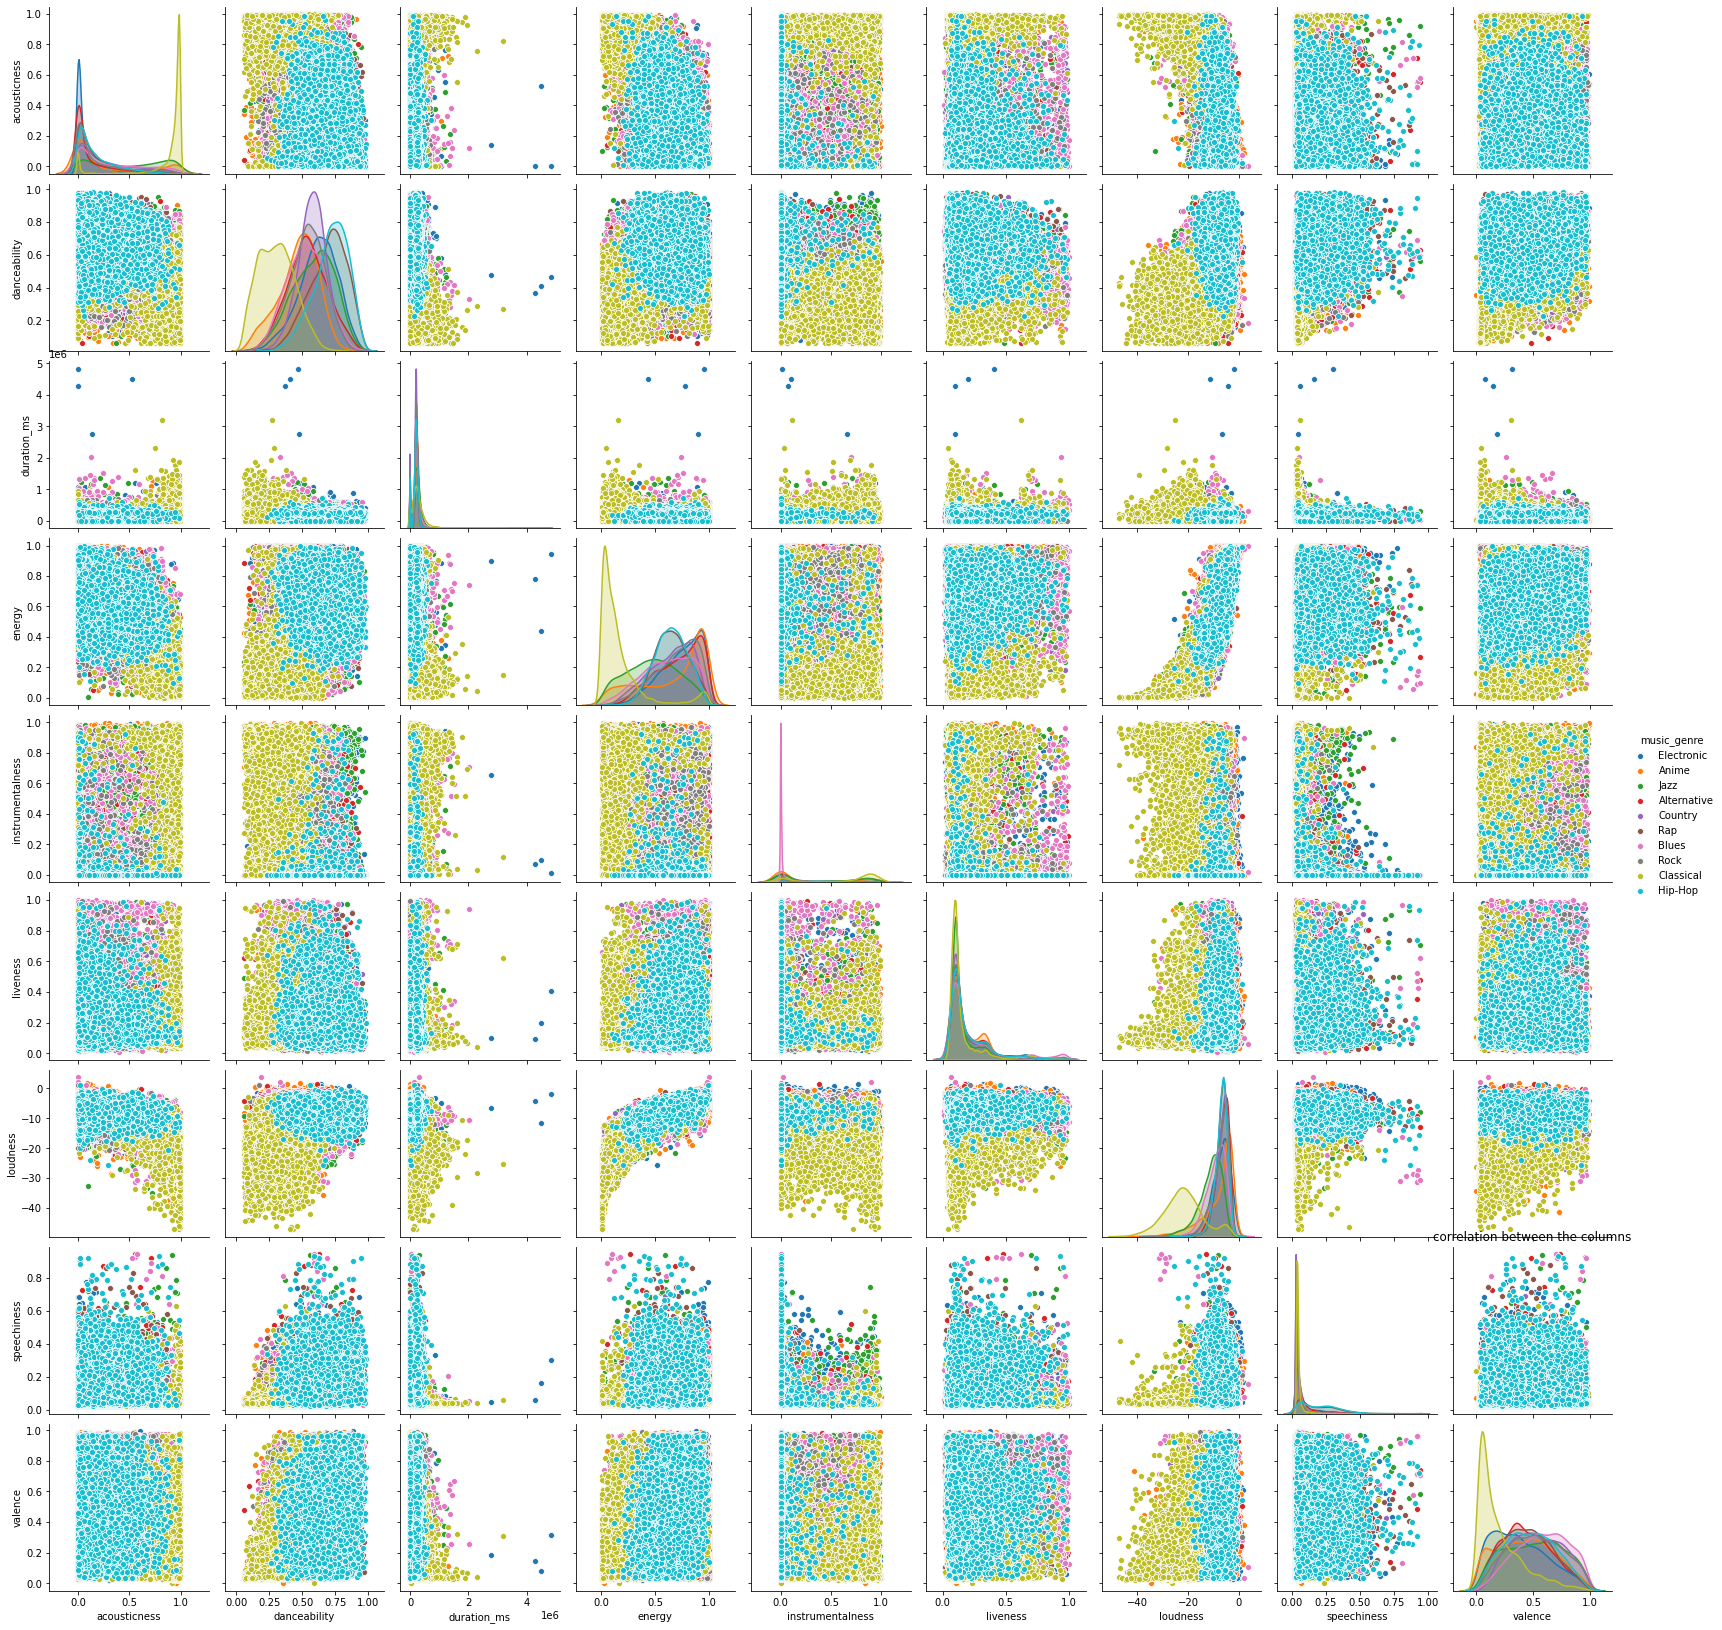

In [6]:
# a pairplot that shows the clusters of genres in the relationships between the features.
sns.pairplot(music[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','valence','music_genre']],hue = 'music_genre')
plt.title("correlation between the columns")

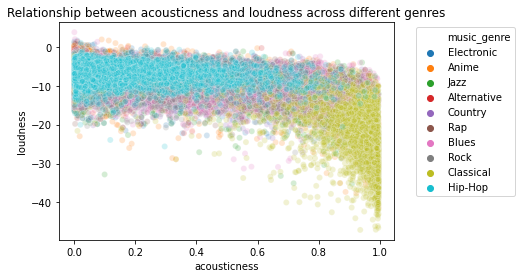

In [7]:
# making a more transparent scatterplot between acousticness and loudness 
# to address the possible issue of overlapping data points
sns.scatterplot(data= music, x= 'acousticness', y= 'loudness', hue="music_genre",alpha = 0.2)
plt.title('Relationship between acousticness and loudness across different genres')
# moving the legend outside the graph
plt.legend(bbox_to_anchor = (1.05,1))

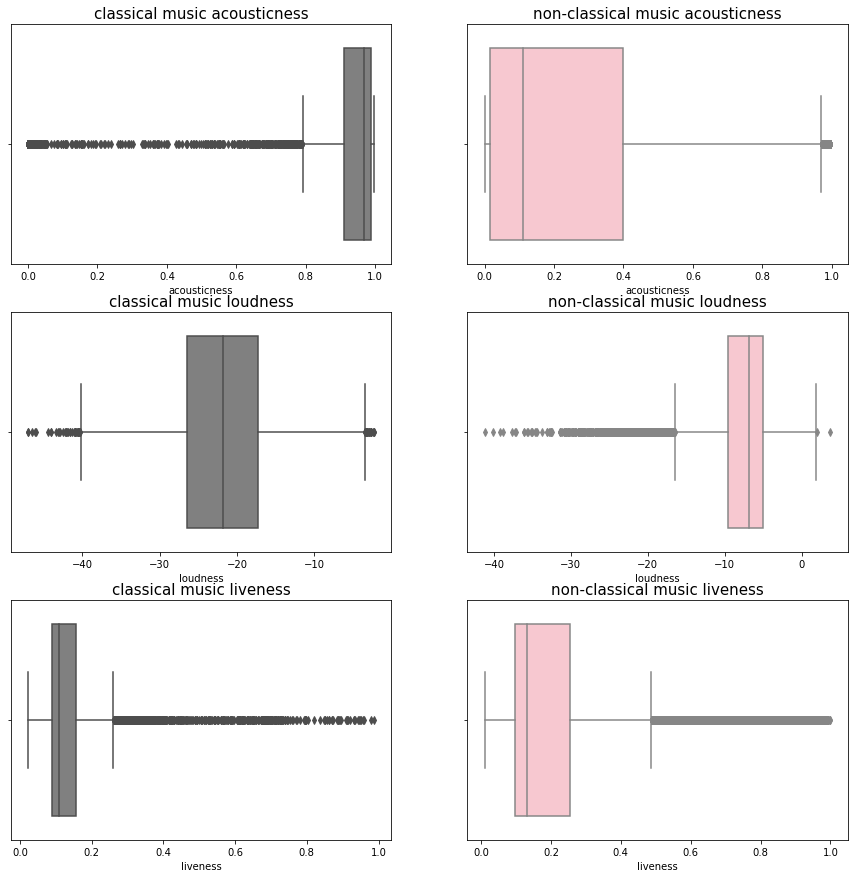

In [8]:
# taking a closer look at the distinction between classical music and other genres
classical_music = music[music['music_genre'] == 'Classical']
non_classical = music[music['music_genre'] != 'Classical']
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(ncols = 2,nrows = 3)
plt_1 = sns.boxplot(classical_music['acousticness'],ax = ax1, color = 'grey').set_title('classical music acousticness',fontsize = 15)
plt_2 = sns.boxplot(non_classical['acousticness'], ax = ax2, color = 'pink').set_title('non-classical music acousticness',fontsize = 15)
plt_3 = sns.boxplot(classical_music['loudness'], ax = ax3, color = 'grey').set_title('classical music loudness',fontsize = 15)
plt_4 = sns.boxplot(non_classical['loudness'], ax = ax4, color = 'pink').set_title('non-classical music loudness',fontsize = 15)
plt_5 = sns.boxplot(classical_music['liveness'], ax = ax5, color = 'grey').set_title('classical music liveness',fontsize = 15)
plt_6 = sns.boxplot(non_classical['liveness'], ax = ax6, color = 'pink').set_title('non-classical music liveness',fontsize = 15)

# adjusting the figure size for better visual experience
fig = plt.gcf()
fig.set_size_inches(15,15)

# Feature engineering 
    - Two functions to deal with issues in features and labels
    - Dummy coding and convert letter labeled data to nominal data represented by numbers

In [9]:
def round_up(string):
    """ Turn string type numbers to float and round it to 
        the nearest 2 decimals 
    
    Input Arguments:
        string: a string type number (str)
    
    Returns: 
        Output: If string can be convereted to float, function returns 
                rounded number represented in the string. Otherwise, 
                function returns nan.(float/nan)

    """
    try:
        output = float(string)
        output = round(output,2)
        return output
    except:
        output = np.nan
        return output 
    

def rap_to_hiphop(input_):
    
    """ Convert any string "Rap" to "Hip-Hop"
   
    Input Arguments:
        string: a string (str)
    
    Returns: 
        Output: string "Hip-Hop"(str)

    """
    output = ''
    if input_ == 'Rap':
        output = 'Hip-Hop' 
        
    else: 
        output = input_
    
    return output

In [10]:
# applying function to "rap" in column "music_genre"
music['music_genre'] = music['music_genre'].apply(rap_to_hiphop)

In [11]:
# creating a new dummy coded column that labels classical music vs non-classical music 
classical_dm = np.where(music['music_genre'] == 'Classical',0,1)
music['classical_dm'] = classical_dm

In [12]:
# mode use 1 and 0 to represent major and minor 
mode_dm = pd.get_dummies(music['mode'],drop_first = True) # major = 0, minor = 1
music['mode_dm'] = mode_dm
music['tempo'] = music['tempo'].apply(round_up)
music = music.dropna(axis = 0, subset = ['tempo'])
# dropping the rows with negative values in "duration_ms"
music = music.drop(music[music['duration_ms'] == -1.0].index,axis = 0)
music = music.drop(columns = ['instance_id','artist_name','track_name','obtained_date','popularity'])

In [13]:
# converting non numerical columns
# initializing a label encoder for the categorical features
key_encoder = preprocessing.LabelEncoder()
music['key_en'] = key_encoder.fit_transform(music['key'])

Text(0.5, 1.0, 'Distribution of each feature')

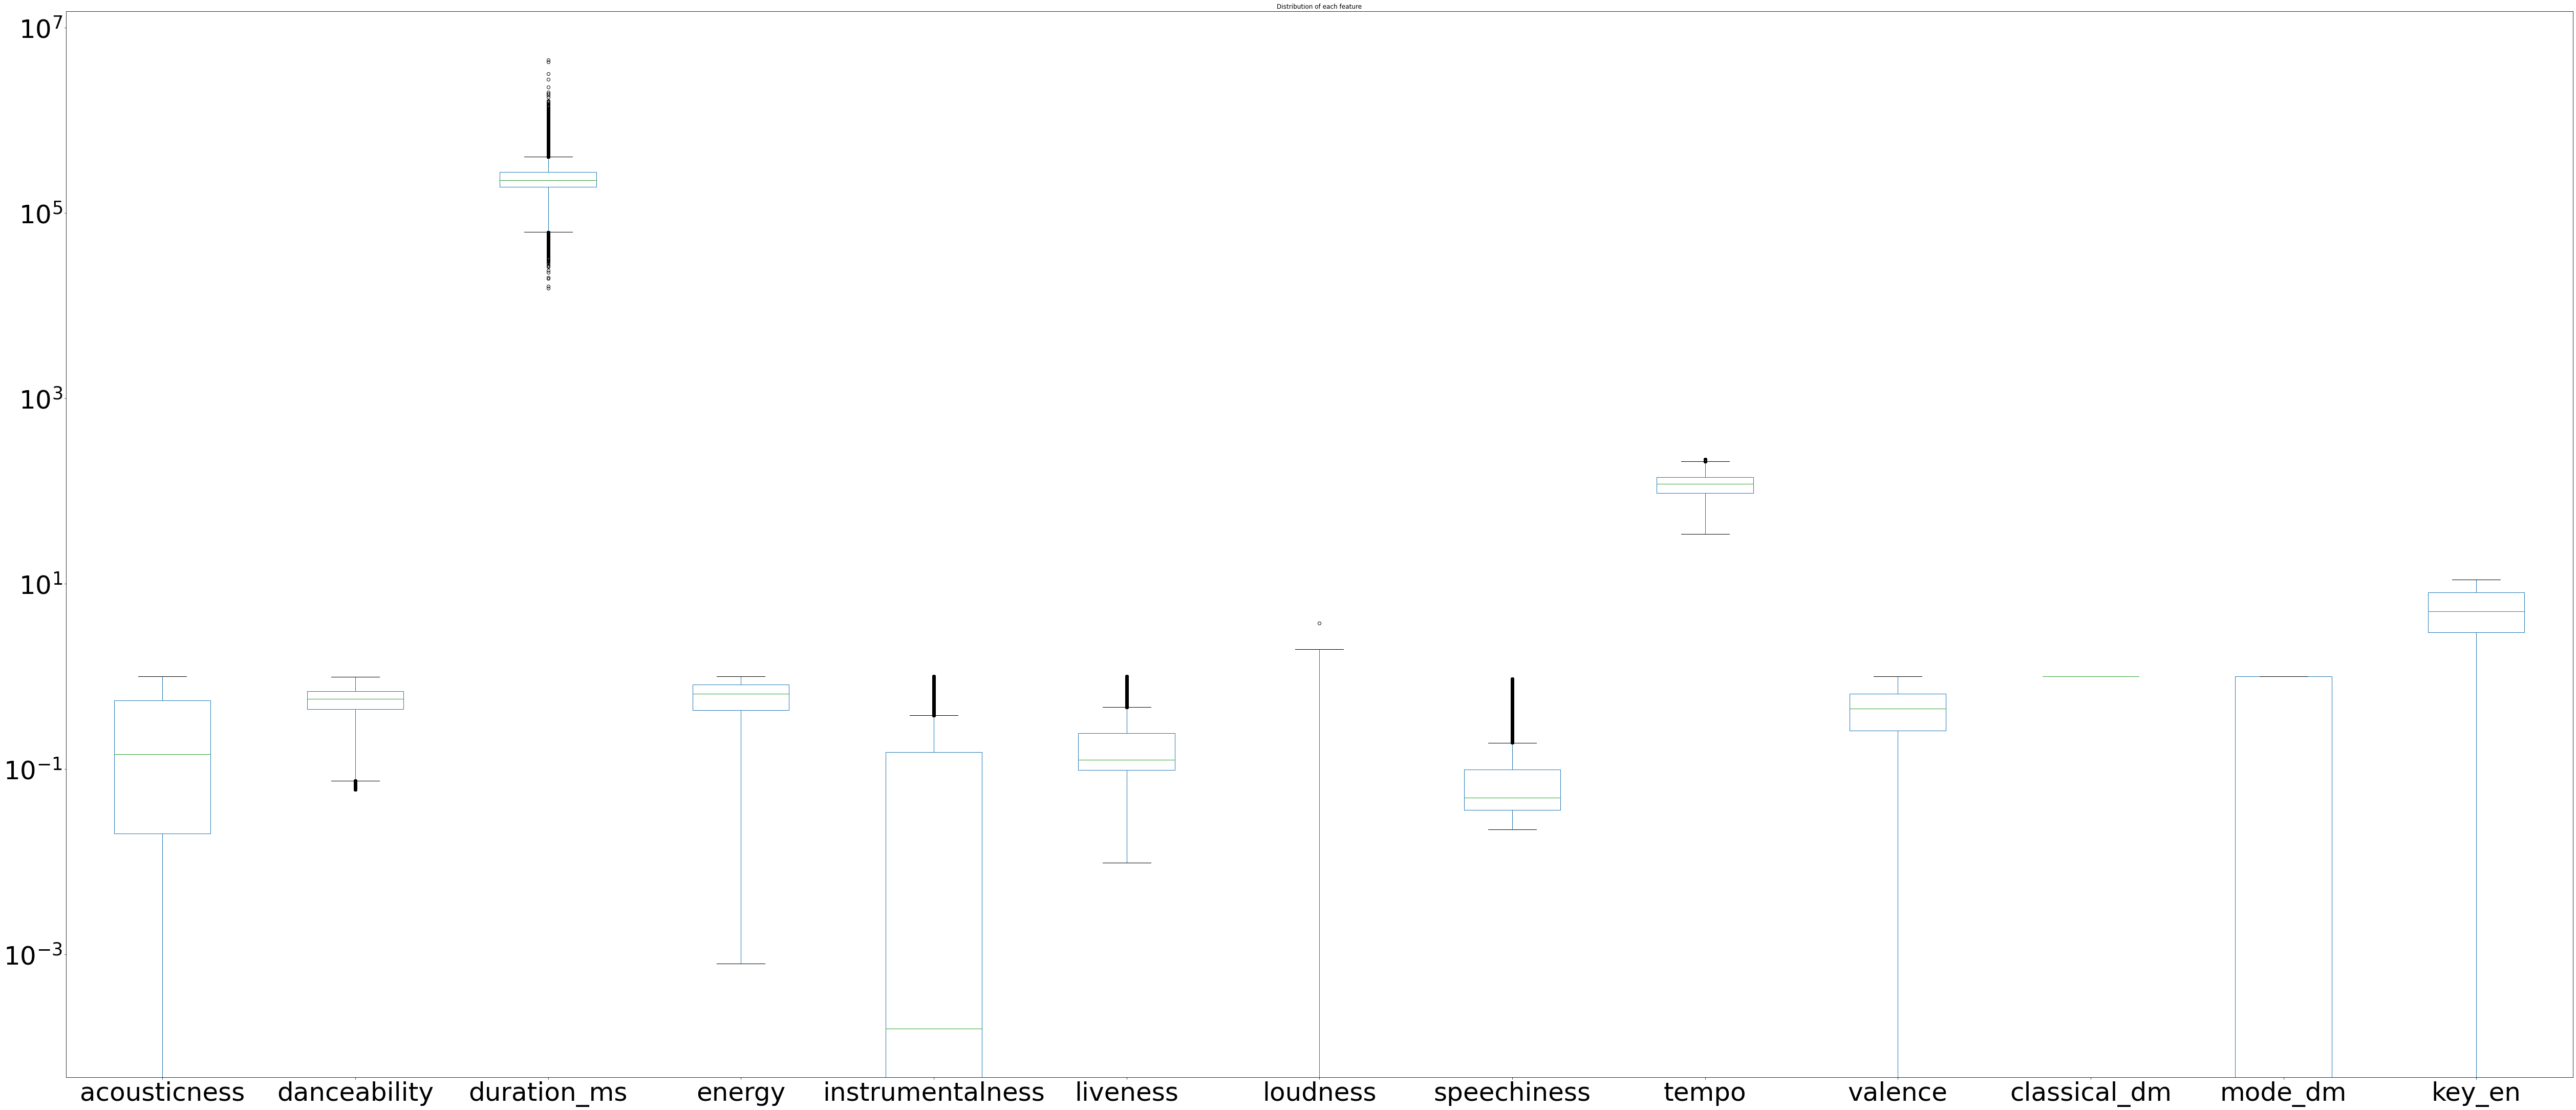

In [14]:
# distribution of the features
music.plot(kind = 'box',figsize =(70,30),fontsize = 50, logy = True)
plt.tight_layout()
plt.title('Distribution of each feature')

In [15]:
# dropping the non-numeric columns
music_new = music.drop(columns = ['key','music_genre','mode'])

In [16]:
X = music_new.drop(columns = 'classical_dm')
y = music_new['classical_dm']
# scaling the features
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size = 0.3,
                                                 stratify = music_new['classical_dm']
                                                )

In [18]:
music[music_new['classical_dm'] == 0]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,classical_dm,mode_dm,key_en
40005,0.861,0.250,568733.0,0.0210,0.035600,E,0.2490,-25.008,Minor,0.0385,123.74,0.0397,Classical,0,1,7
40006,0.788,0.119,271520.0,0.3460,0.000022,C#,0.1290,-8.093,Major,0.0376,64.63,0.1350,Classical,0,0,4
40007,0.991,0.183,210533.0,0.0702,0.000059,A#,0.4590,-22.228,Major,0.0521,71.22,0.1180,Classical,0,0,1
40008,0.963,0.203,196088.0,0.1000,0.849000,F#,0.1390,-19.911,Minor,0.0390,66.72,0.0596,Classical,0,1,9
40010,0.890,0.455,174613.0,0.2710,0.229000,D#,0.0766,-15.999,Major,0.0408,117.31,0.5690,Classical,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44999,0.983,0.251,531280.0,0.0569,0.883000,A,0.1220,-29.746,Major,0.0501,71.01,0.0830,Classical,0,0,0
45000,0.911,0.326,368640.0,0.1330,0.000000,G,0.1300,-20.493,Major,0.0557,92.09,0.2060,Classical,0,0,10
45001,0.965,0.126,514213.0,0.2040,0.869000,B,0.1060,-16.474,Major,0.0395,82.44,0.0387,Classical,0,0,2
45003,0.985,0.123,259573.0,0.0174,0.906000,E,0.1250,-23.671,Major,0.0408,71.70,0.0352,Classical,0,0,7


# Random Forest Classifier

In [21]:
# Creating a function that output f1 scores 
# We will run this to compare the performance of the base model and the tuned model 
def model_eval(model, testing_features, testing_labels):
    
    '''prints evaluation scores for machine learning models, including 
       micro averaged f1 score, accuracy, precision, and recall 
    
    Input arguments:
        model: machine learning model
        testing_features: features in the test set (array)
        testing_labels: labels in the test set
        
    Output:
        f1: micro averaged f1 score (float)
       
    '''
    
    pred = model.predict(testing_features)
    roc_score = roc_auc_score(testing_labels, pred)
    acc = accuracy_score(testing_labels, pred)
    report = classification_report(testing_labels, pred,output_dict = True)
    precision = report['0']['precision']
    recall = report['0']['recall']
    f1 = report['0']['f1-score']
    
    print('Model Performance')
    print('F1_score: ' + str(f1))
    print('Accuracy = '+ str(acc))
    print('ROC: ' + str(roc_score))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    
    return f1

In [54]:
# initializing a random forest classifier 
initial_forest = RandomForestClassifier(n_estimators= 100,
                                        max_depth = 2
)
initial_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2)

In [20]:
# the parameters of initial random forest
initial_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [57]:
# use the model to predict labels from 
y_pred_test_i = initial_forest.predict(X_test)
y_pred_train_i = initial_forest.predict(X_train)

In [58]:
print(classification_report(y_test, y_pred_test_i))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1211
           1       0.97      0.98      0.97     10957

    accuracy                           0.95     12168
   macro avg       0.88      0.85      0.86     12168
weighted avg       0.95      0.95      0.95     12168



Text(33.0, 0.5, 'Predicted Class')

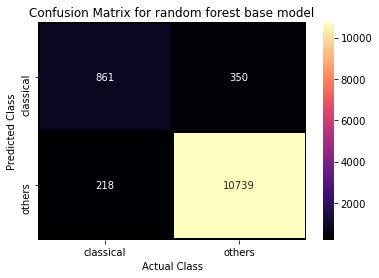

In [66]:
# taking a deeper look at how the base model classifies instances into the two classses
sns.heatmap(confusion_matrix(y_test, y_pred_test_i),
    annot = True,
    cmap = "magma",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['classical','others'],
    yticklabels = ['classical','others'],
    fmt = '.0F'
           )
plt.title('Confusion Matrix for random forest base model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

In [23]:
model_params = {'n_estimators':[int(x) for x in np.linspace(start = 50, stop = 1000, num = 20)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
               'min_samples_leaf': [2, 3, 4, 5, 6],
               'bootstrap': [True, False]
               }

Random_F = RandomForestClassifier()
random_search = RandomizedSearchCV(Random_F,model_params, n_iter = 10, cv = 5)
search = random_search.fit(X_train,y_train)

In [24]:
# getting the best parameters for the random forest model
search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_leaf=4, n_estimators=350)

In [33]:
forest = RandomForestClassifier(bootstrap=False, 
                                max_depth=90, 
                                max_features='sqrt',
                                min_samples_leaf=4, 
                                n_estimators=350
                               )
                                                                
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_leaf=4, n_estimators=350)

In [34]:
y_pred_test = forest.predict(X_test)
y_pred_train = forest.predict(X_train)

In [61]:
print('===== Initial model performance ===== \n')
i = model_eval(initial_forest, X_test, y_test)
print('\n')
print('===== Tuned model performance ===== \n')
t = model_eval(forest, X_test, y_test)
print('\n')
print('F1 score on class "classical music" is improved by ' + str(round((t-i)*100/i)) + ' %')

===== Initial model performance ===== 

Model Performance
F1_score: 0.7519650655021834
Accuracy = 0.9533201840894149
ROC: 0.8455433510185112
Precision: 0.7979610750695088
Recall: 0.7109826589595376


===== Tuned model performance ===== 

Model Performance
F1_score: 0.8153912667531344
Accuracy = 0.9649079552925707
ROC: 0.8820920109063829
Precision: 0.8557168784029038
Recall: 0.7786952931461602


F1 score on class "classical music" is improved by 8 %


In [36]:
print("Random forest test set score")
print(classification_report(y_test, y_pred_test))
print(classification_report(y_train, y_pred_train))

Random forest test set score
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1211
           1       0.98      0.99      0.98     10957

    accuracy                           0.96     12168
   macro avg       0.92      0.88      0.90     12168
weighted avg       0.96      0.96      0.96     12168

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2825
           1       0.99      1.00      1.00     25567

    accuracy                           0.99     28392
   macro avg       0.99      0.96      0.98     28392
weighted avg       0.99      0.99      0.99     28392



In [37]:
# showing the relevant f1 scores
print('===== testing macro f1 score  =====')
print(f1_score(y_test, y_pred_test,average = 'macro'))
print('===== training macro f1 score  =====')
print(f1_score(y_train, y_pred_train,average = 'macro'))
print('===== testing f1 score  =====')
print(f1_score(y_test, y_pred_test))
print('===== training f1 score  =====')
print(f1_score(y_train, y_pred_train))

===== testing macro f1 score  =====
0.8980012229874286
===== training macro f1 score  =====
0.9756502971072695
===== testing f1 score  =====
0.9806111792217228
===== training f1 score  =====
0.9953027851950026


=========== Random Forest AUC score ==========
0.8820920109063829



Text(0.5, 1.0, ' Random Forest ROC curve')

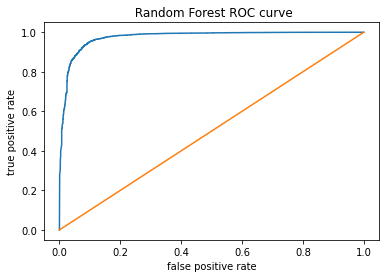

In [38]:
# plotting the ROC curve and printing the AUC score for the Random Forest Model 
print('=========== Random Forest AUC score ==========')
print(metrics.roc_auc_score(y_test,y_pred_test))
print('===============================================\n')
forest_y_score = forest.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,forest_y_score)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' Random Forest ROC curve')

Text(33.0, 0.5, 'Predicted Class')

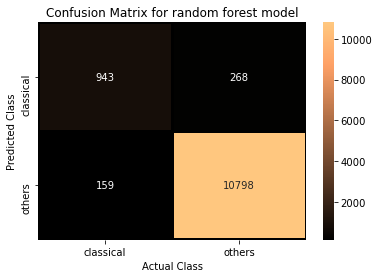

In [39]:
# taking a deeper look at how the model classifies instances into the two classses
sns.heatmap(confusion_matrix(y_test, y_pred_test),
    annot = True,
    cmap = "copper",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['classical','others'],
    yticklabels = ['classical','others'],
    fmt = '.0F'
           )
plt.title('Confusion Matrix for random forest model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

Text(0.5, 1.0, 'Feature importances in the Random Forest Classifier')

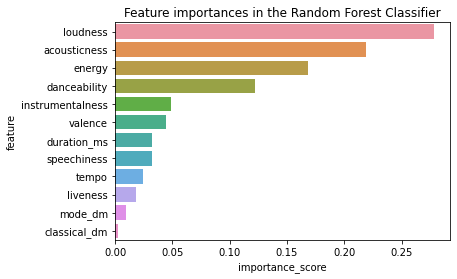

In [40]:
# ranking the features based on their significance in the process of classification
importance = forest.feature_importances_
feature_name = music_new.columns[:-1]
feature_imp = pd.DataFrame()
feature_imp['feature'] = feature_name
feature_imp['importance_score'] = importance
feature_imp = feature_imp.sort_values(by = 'importance_score',ascending = False)
sns.barplot(data = feature_imp,x= 'importance_score', y= 'feature', orient = 'horizontal')
plt.title('Feature importances in the Random Forest Classifier')